In [2]:
%load_ext autoreload
%autoreload 2

import multiprocessing
from typing import Type, Dict
import pandas
import os
from collections import defaultdict

import sys
sys.path.append("compute")

import tokenizer_interface
import tiktoken
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

/homes/cdt21/aleks/tokenization-fairness/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
t = tokenizer_interface.OpenAI_cl100k_base()

tokens =list(t.encoder.decode_single_token_bytes(i) for i in range(50000))
print(tokens[:20])
print(tokens[1000:1010])
print(tokens[10000:10010])

[b'!', b'"', b'#', b'$', b'%', b'&', b"'", b'(', b')', b'*', b'+', b',', b'-', b'.', b'/', b'0', b'1', b'2', b'3', b'4']
[b'indow', b'lement', b'pect', b'ash', b'[i', b' use', b'.F', b'pec', b' ad', b'ove']
[b'.grid', b'Results', b'azz', b' daughter', b' curr', b'175', b' lin', b' south', b'forms', b' OUT']


In [4]:
class CustomTokenizer(tokenizer_interface.OpenAITokenizer):

    tokenizer_name="Custom"

    def __init__(self, vocab: Dict[str, int], base_tokenizer: tokenizer_interface.OpenAITokenizer):
        self.encoder = tiktoken.Encoding(
            name="CustomTokenizer",
            pat_str=base_tokenizer.encoder._pat_str,
            mergeable_ranks=vocab,
            special_tokens=base_tokenizer.encoder._special_tokens
        )

In [5]:
vocab = {k: v for k, v in sorted(tokenizer_interface.OpenAI_cl100k_base().encoder._mergeable_ranks.items(), key=lambda item: item[1]) if v < 256}
tokenizer = CustomTokenizer(vocab=vocab, base_tokenizer=t)

In [6]:
DATASET_PATH = "flores200_dataset"
lang = "eng_Latn"
with open(f"{DATASET_PATH}/dev/{lang}.dev", 'r') as file:
    data_dev = file.read().split('\n')
with open(f"{DATASET_PATH}/devtest/{lang}.devtest", 'r') as file:
    data_devtest = file.read().split('\n')
data = data_dev + data_devtest
data_str = " ".join(data)

In [7]:
vocab_sizes = list(np.linspace(5_000, 100_000, 20, endpoint=True))
tokens_necessary = []
for vocab_size in vocab_sizes:
    vocab = {k: v for k, v in sorted(tokenizer_interface.OpenAI_cl100k_base().encoder._mergeable_ranks.items(), key=lambda item: item[1]) if v < vocab_size}
    tokenizer = CustomTokenizer(vocab=vocab, base_tokenizer=t)
    tokens = tokenizer.encode(data_str)
    tokens_necessary.append(len(tokens))

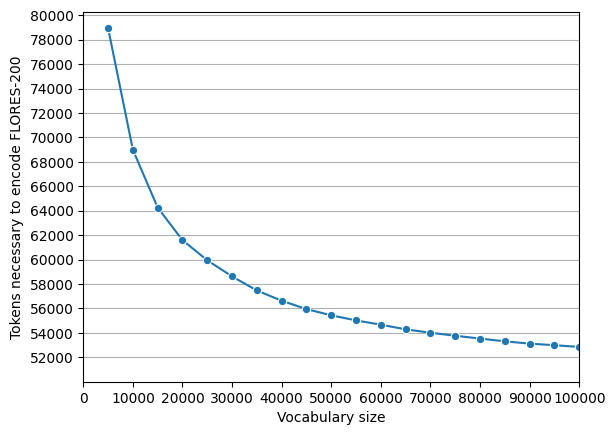

In [11]:
sns.lineplot(x=vocab_sizes, y=tokens_necessary, marker="o")
plt.ylim((50000, None))
plt.xlim((0, 100_000))
# change the number of x ticks
plt.xticks(np.linspace(0, 100_000, 11, endpoint=True))
plt.yticks(np.linspace(52_000, 80_000, 15, endpoint=True))
plt.xlabel("Vocabulary size")
plt.ylabel("Tokens necessary to encode FLORES-200")
plt.grid(axis="y")
plt.savefig("how_much_will_english_lose.pdf")


In [9]:
for vs, tl in zip(vocab_sizes, tokens_necessary):
    print(f"Vocabulary size {int(vs):>6} requires {tl} tokens in total")

Vocabulary size   5000 requires 78950 tokens in total
Vocabulary size  10000 requires 68986 tokens in total
Vocabulary size  15000 requires 64255 tokens in total
Vocabulary size  20000 requires 61587 tokens in total
Vocabulary size  25000 requires 59941 tokens in total
Vocabulary size  30000 requires 58619 tokens in total
Vocabulary size  35000 requires 57468 tokens in total
Vocabulary size  40000 requires 56630 tokens in total
Vocabulary size  45000 requires 55946 tokens in total
Vocabulary size  50000 requires 55435 tokens in total
Vocabulary size  55000 requires 55018 tokens in total
Vocabulary size  60000 requires 54668 tokens in total
Vocabulary size  65000 requires 54286 tokens in total
Vocabulary size  70000 requires 54011 tokens in total
Vocabulary size  75000 requires 53763 tokens in total
Vocabulary size  80000 requires 53532 tokens in total
Vocabulary size  85000 requires 53305 tokens in total
Vocabulary size  90000 requires 53118 tokens in total
Vocabulary size  95000 requi